# Supernova distances and redshifts (part 2)

In [1]:
import numpy as np
import pylab as plt
import scipy.stats

from astroML.datasets import generate_mu_z
from astropy.cosmology import FlatLambdaCDM

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import GridSearchCV

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

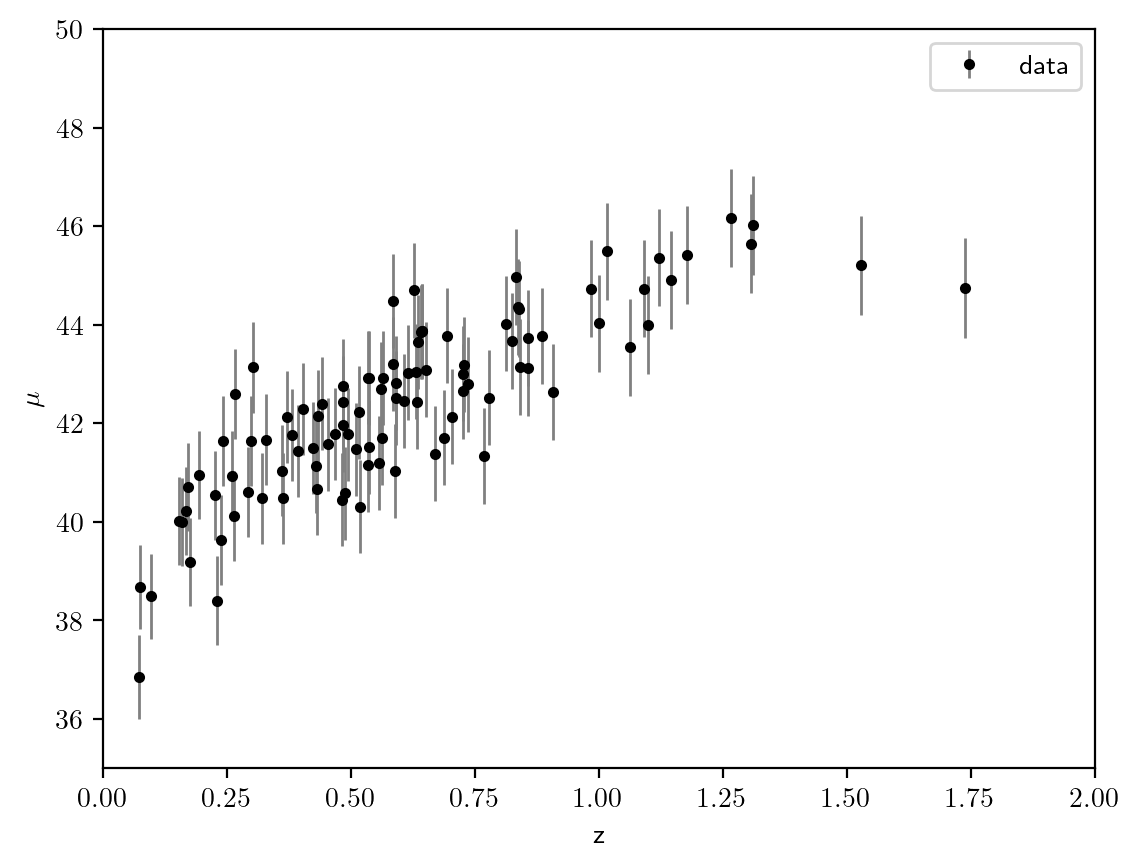

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

In [3]:
x = z_sample[:,np.newaxis]
y = mu_sample[:,np.newaxis]
dy = dmu[:,np.newaxis]

## GPR

In [4]:
kernel = 1.0 * kernels.RBF(1.0) # constant + rbf kernel
GPR = GaussianProcessRegressor(kernel=kernel, alpha=dmu ** 2, random_state=42)
GPR.fit(x, y)

x_grid = np.linspace(0, 2, 200)
f, f_err = GPR.predict(x_grid[:,np.newaxis], return_std=True)

print("Optimized kernel:", GPR.kernel_)
print("Amplitude:", np.exp(GPR.kernel_.theta[0]))      # associated to const kernel (vertical scale of the function) 
print("Length scale:", np.exp(GPR.kernel_.theta[1]))   # associated to RBF kernel (horizontal scale)

Optimized kernel: 30.7**2 * RBF(length_scale=3.9)
Amplitude: 941.4309603667124
Length scale: 3.8984532691993166


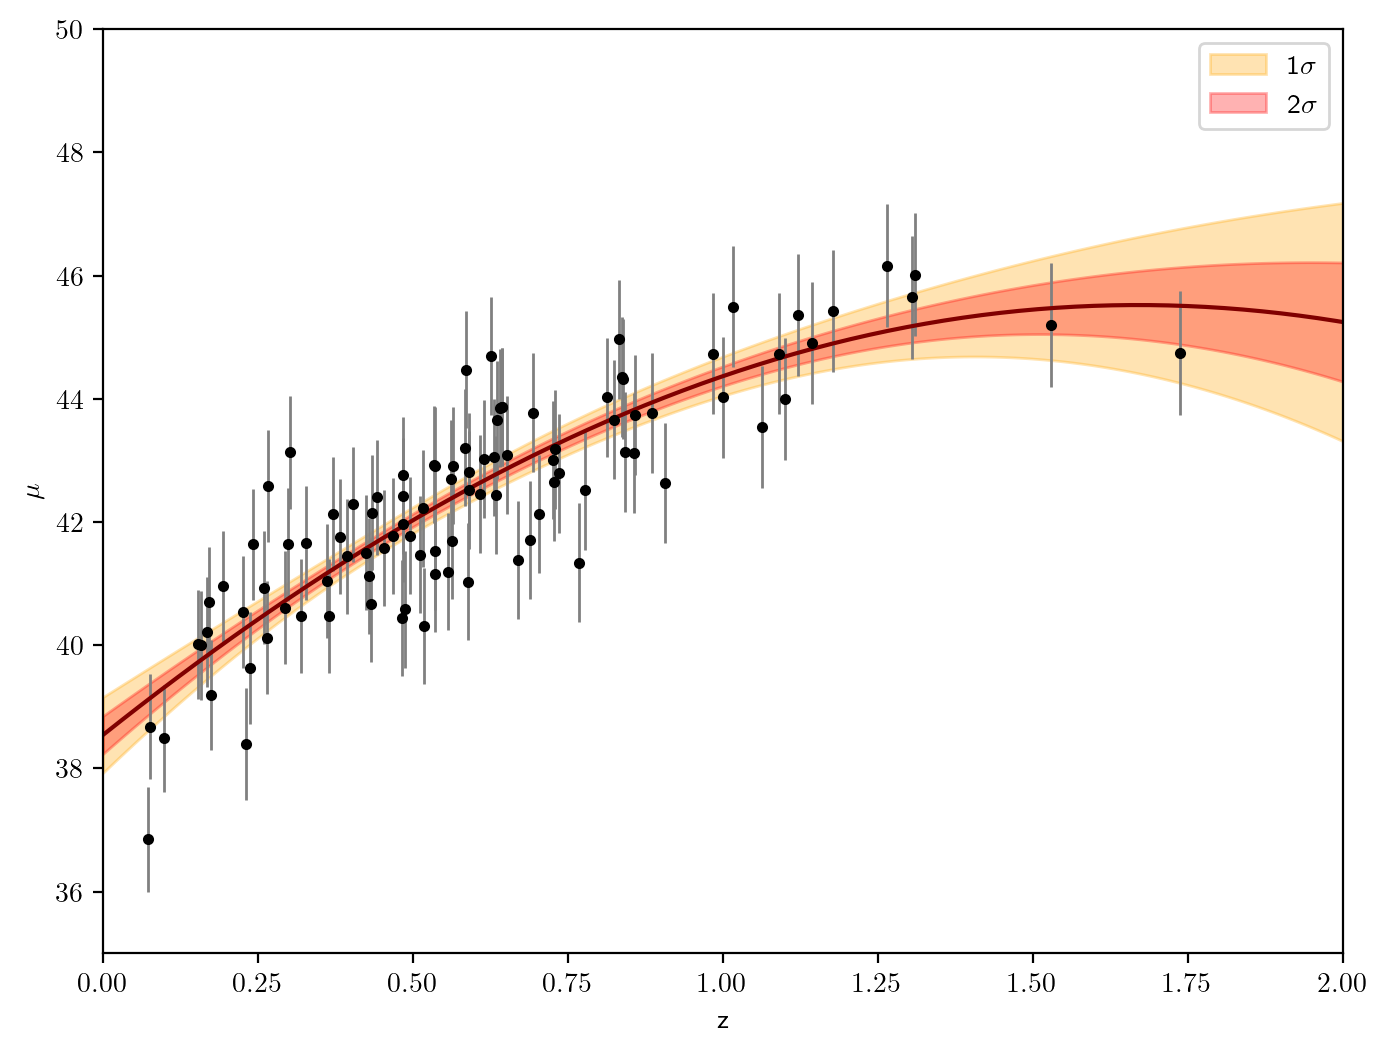

In [5]:
plt.figure(figsize=(8,6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.plot(x_grid,f, color='maroon')
plt.fill_between(x_grid, f - 2 * f_err, f + 2 * f_err, color='orange', alpha=0.3, label=r'1$\sigma$')
plt.fill_between(x_grid, f - 1 * f_err, f + 1 * f_err, color='red', alpha=0.3, label=r'2$\sigma$')

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='best')
plt.show()

Optimize hyperparameters.

## Parameter estimation

Predicted relationship between the distance module $\mu$ and the redshift $z$ (for flat universe):

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

where $\Omega_\Lambda = 1-\Omega_m $.

In [6]:
def dist_module(z, H0, Om):
    lambda_CDM = FlatLambdaCDM(H0=H0, Om0=Om)
    return lambda_CDM.distmod(z).value  #only value, without units

In [7]:
def LogLikelihood(theta, z_sample, mu_sample, dmu):
    H0, Om = theta
    if Om > 0:
        mu_model = dist_module(z_sample, H0, Om)
        gauss = scipy.stats.norm(loc=mu_model, scale=dmu)
        return np.sum(gauss.logpdf(mu_sample))
    else:
        return -np.inf

In [8]:
def prior_transform(u):
    theta = np.zeros(len(u))
    theta_min = np.array([30, 0.1])
    theta_max = np.array([100, 1])

    theta[0] = scipy.stats.uniform(loc=theta_min[0], scale=theta_max[0]-theta_min[0]).ppf(u[0])
    theta[1] = scipy.stats.uniform(loc=theta_min[1], scale=theta_max[1]-theta_min[1]).ppf(u[1])
    
    return theta

In [9]:
ndim = 2             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, prior_transform, ndim, logl_args=[z_sample, mu_sample, dmu], nlive=200)

sampler.run_nested()
sresults = sampler.results

839it [00:08, 96.00it/s, +200 | bound: 1 | nc: 1 | ncall: 7889 | eff(%): 13.513 | loglstar:   -inf < -132.814 <    inf | logz: -135.341 +/-  0.089 | dlogz:  0.001 >  0.209]


#### Runplot 

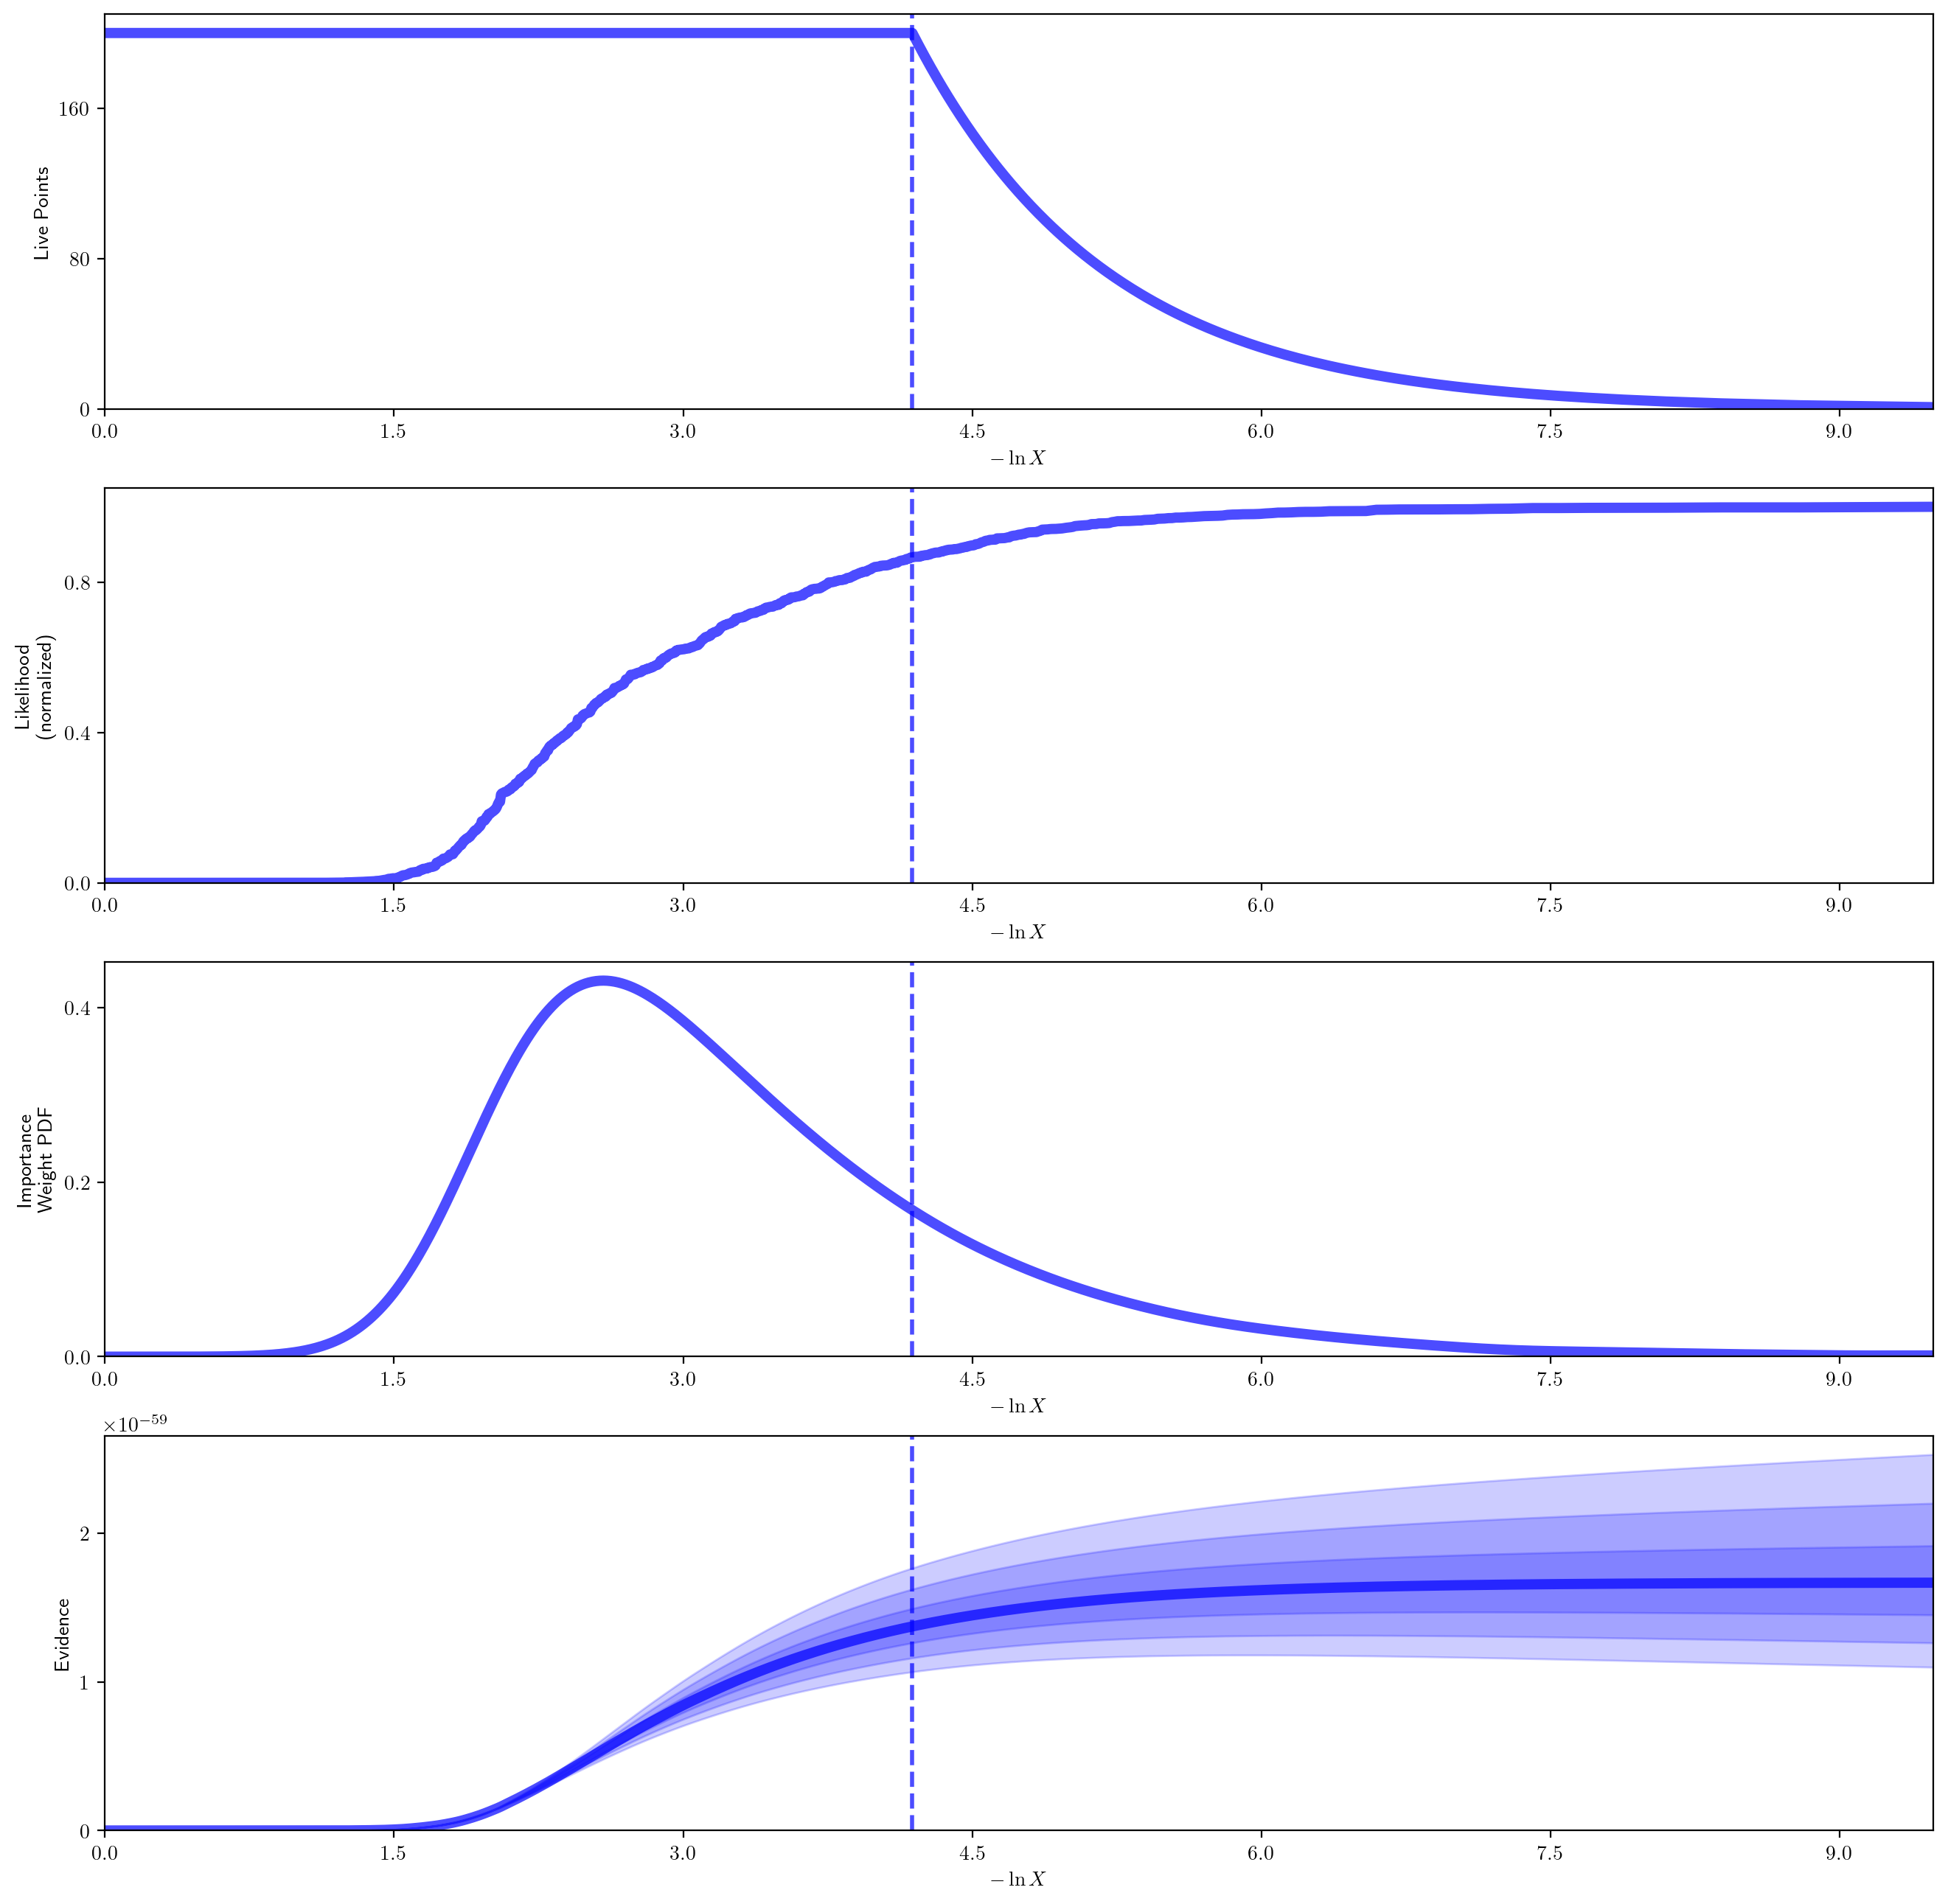

In [10]:
runplot_fig, runplot_axes = dyplot.runplot(sresults)

#### Traceplots

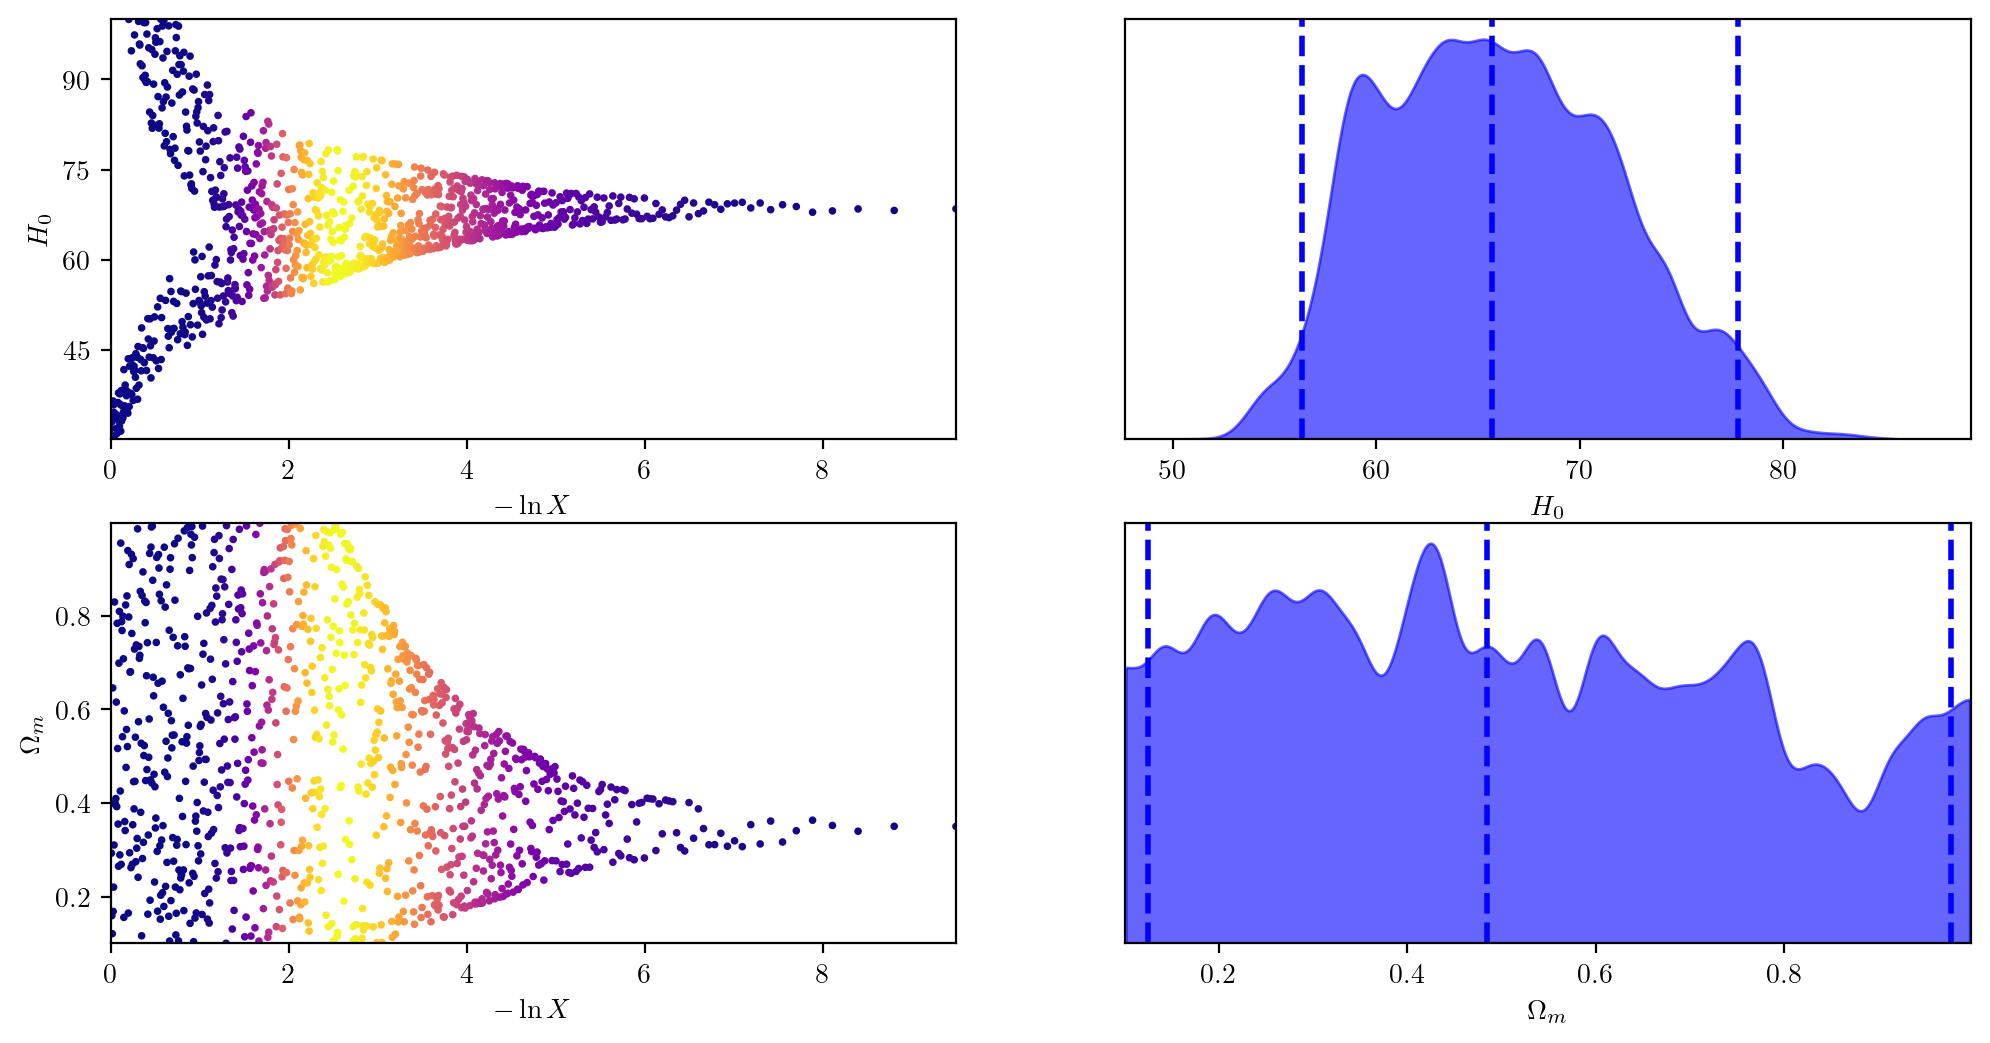

In [11]:
labels = ["$H_0$", "$\\Omega_m$"]
traceplot_fig, traceplot_axes = dyplot.traceplot(sresults, labels=labels)

#### Corner plots

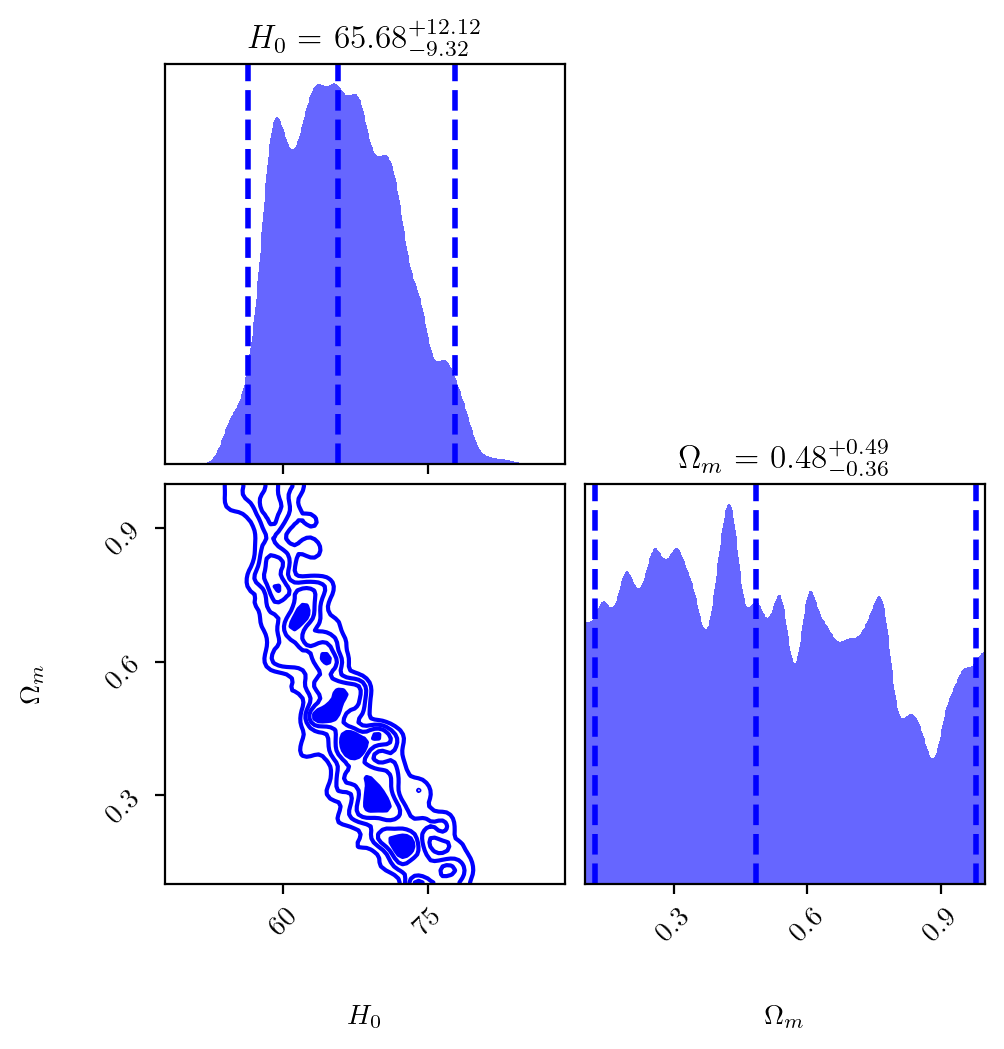

In [12]:
corner_fig, corner_axes = dyplot.cornerplot(sresults, color='b', show_titles=True, max_n_ticks=3, labels=labels)

#### Statistics

In [13]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

In [14]:
percentiles = [0.50, 0.16, 0.84]
quantiles = []

for sample in samples.T:
    q = dyfunc.quantile(sample, percentiles, weights=weights)
    quantiles.append(q)

quantiles = np.array(quantiles)

labels = ["H0","Om"]
print("     Median                 90% credible regions")
for i,l in enumerate(labels):
    print(l+"   "+str(quantiles[i,0])+"      "+str(quantiles[i,1])+" - "+str(quantiles[i,2]))

     Median                 90% credible regions
H0   65.67730415388955      59.6626356902014 - 71.98615442830261
Om   0.48427973373316086      0.23167706237872587 - 0.7841115645279297


In [15]:
mean, cov = dyfunc.mean_and_cov(samples, weights)

print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Mean and covariance of parameters are: [65.9834709   0.50877332]
[[33.14265318 -1.23831201]
 [-1.23831201  0.06197843]]


In [16]:
log_evidence = sresults.logz[-1]          
log_evidence_error = sresults.logzerr[-1]

#compute the evidence
evidence = np.exp(log_evidence)
print("Bayesian evidence:", evidence)

#propagate the error 
evidence_error = evidence * log_evidence_error
print("Bayesian evidence error:", evidence_error)

Bayesian evidence: 1.6674715603070959e-59
Bayesian evidence error: 2.318831015214271e-60


#### Plot

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


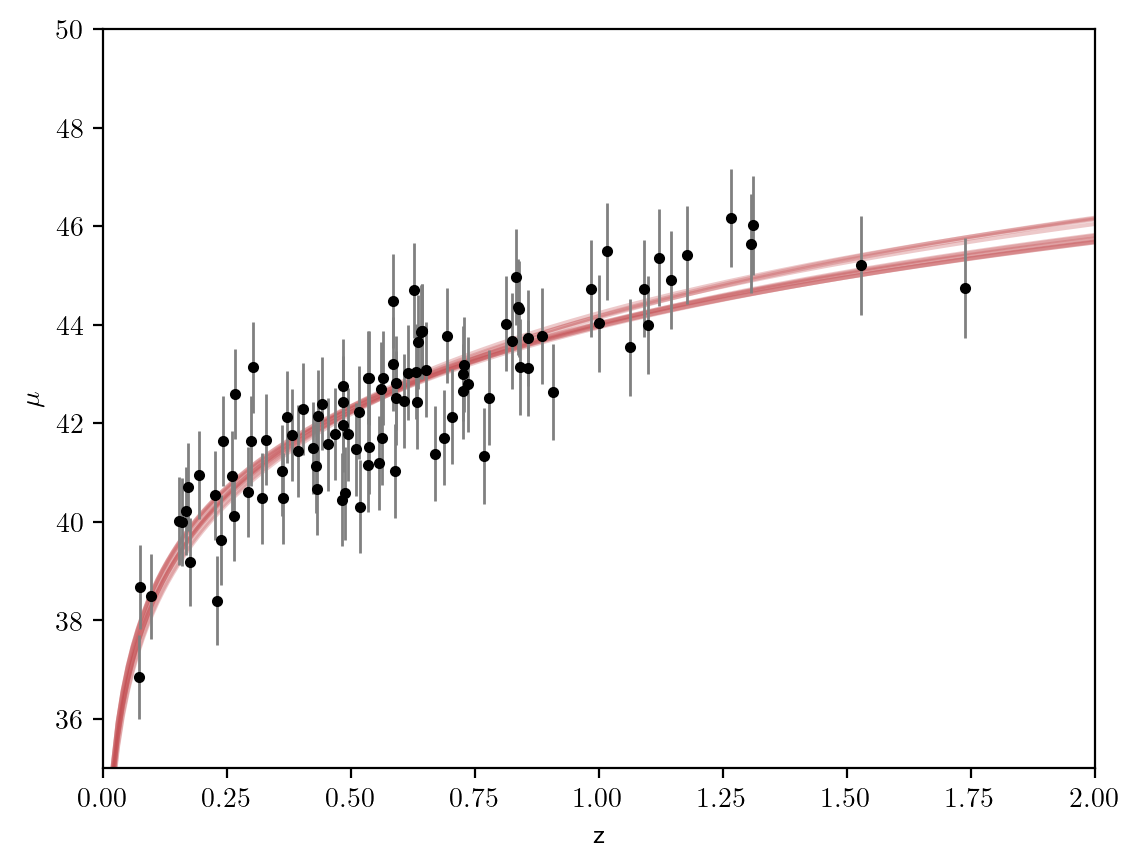

In [17]:
samples_equal = dyfunc.resample_equal(samples, weights)

for H0,Om in samples_equal[::100]:
    plt.plot(x_grid, dist_module(x_grid, H0, Om),c='C2',alpha=0.3)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### Model without dark energy

In [18]:
def LogLikelihood_noDE(theta, z_sample, mu_sample, dmu):
    H0 = float(theta[0])
    Om = 1
    
    mu_model = dist_module(z_sample, H0, Om)
    gauss = scipy.stats.norm(loc=mu_model, scale=dmu)
    return np.sum(gauss.logpdf(mu_sample))

In [19]:
def prior_transform_noDE(u):
    theta_min = 30
    theta_max = 100

    theta = scipy.stats.uniform(loc=theta_min, scale=theta_max-theta_min).ppf(u)
    
    return theta

In [20]:
ndim_noDM = 1             # number of parameters in the model

sampler_noDM = dynesty.NestedSampler(LogLikelihood_noDE, prior_transform_noDE, ndim_noDM, logl_args=[z_sample, mu_sample, dmu], nlive=200)

sampler_noDM.run_nested()
sresults_noDM = sampler_noDM.results

840it [00:06, 134.18it/s, +200 | bound: 1 | nc: 1 | ncall: 7766 | eff(%): 13.746 | loglstar:   -inf < -133.530 <    inf | logz: -136.050 +/-  0.090 | dlogz:  0.001 >  0.209]


#### Runplot 

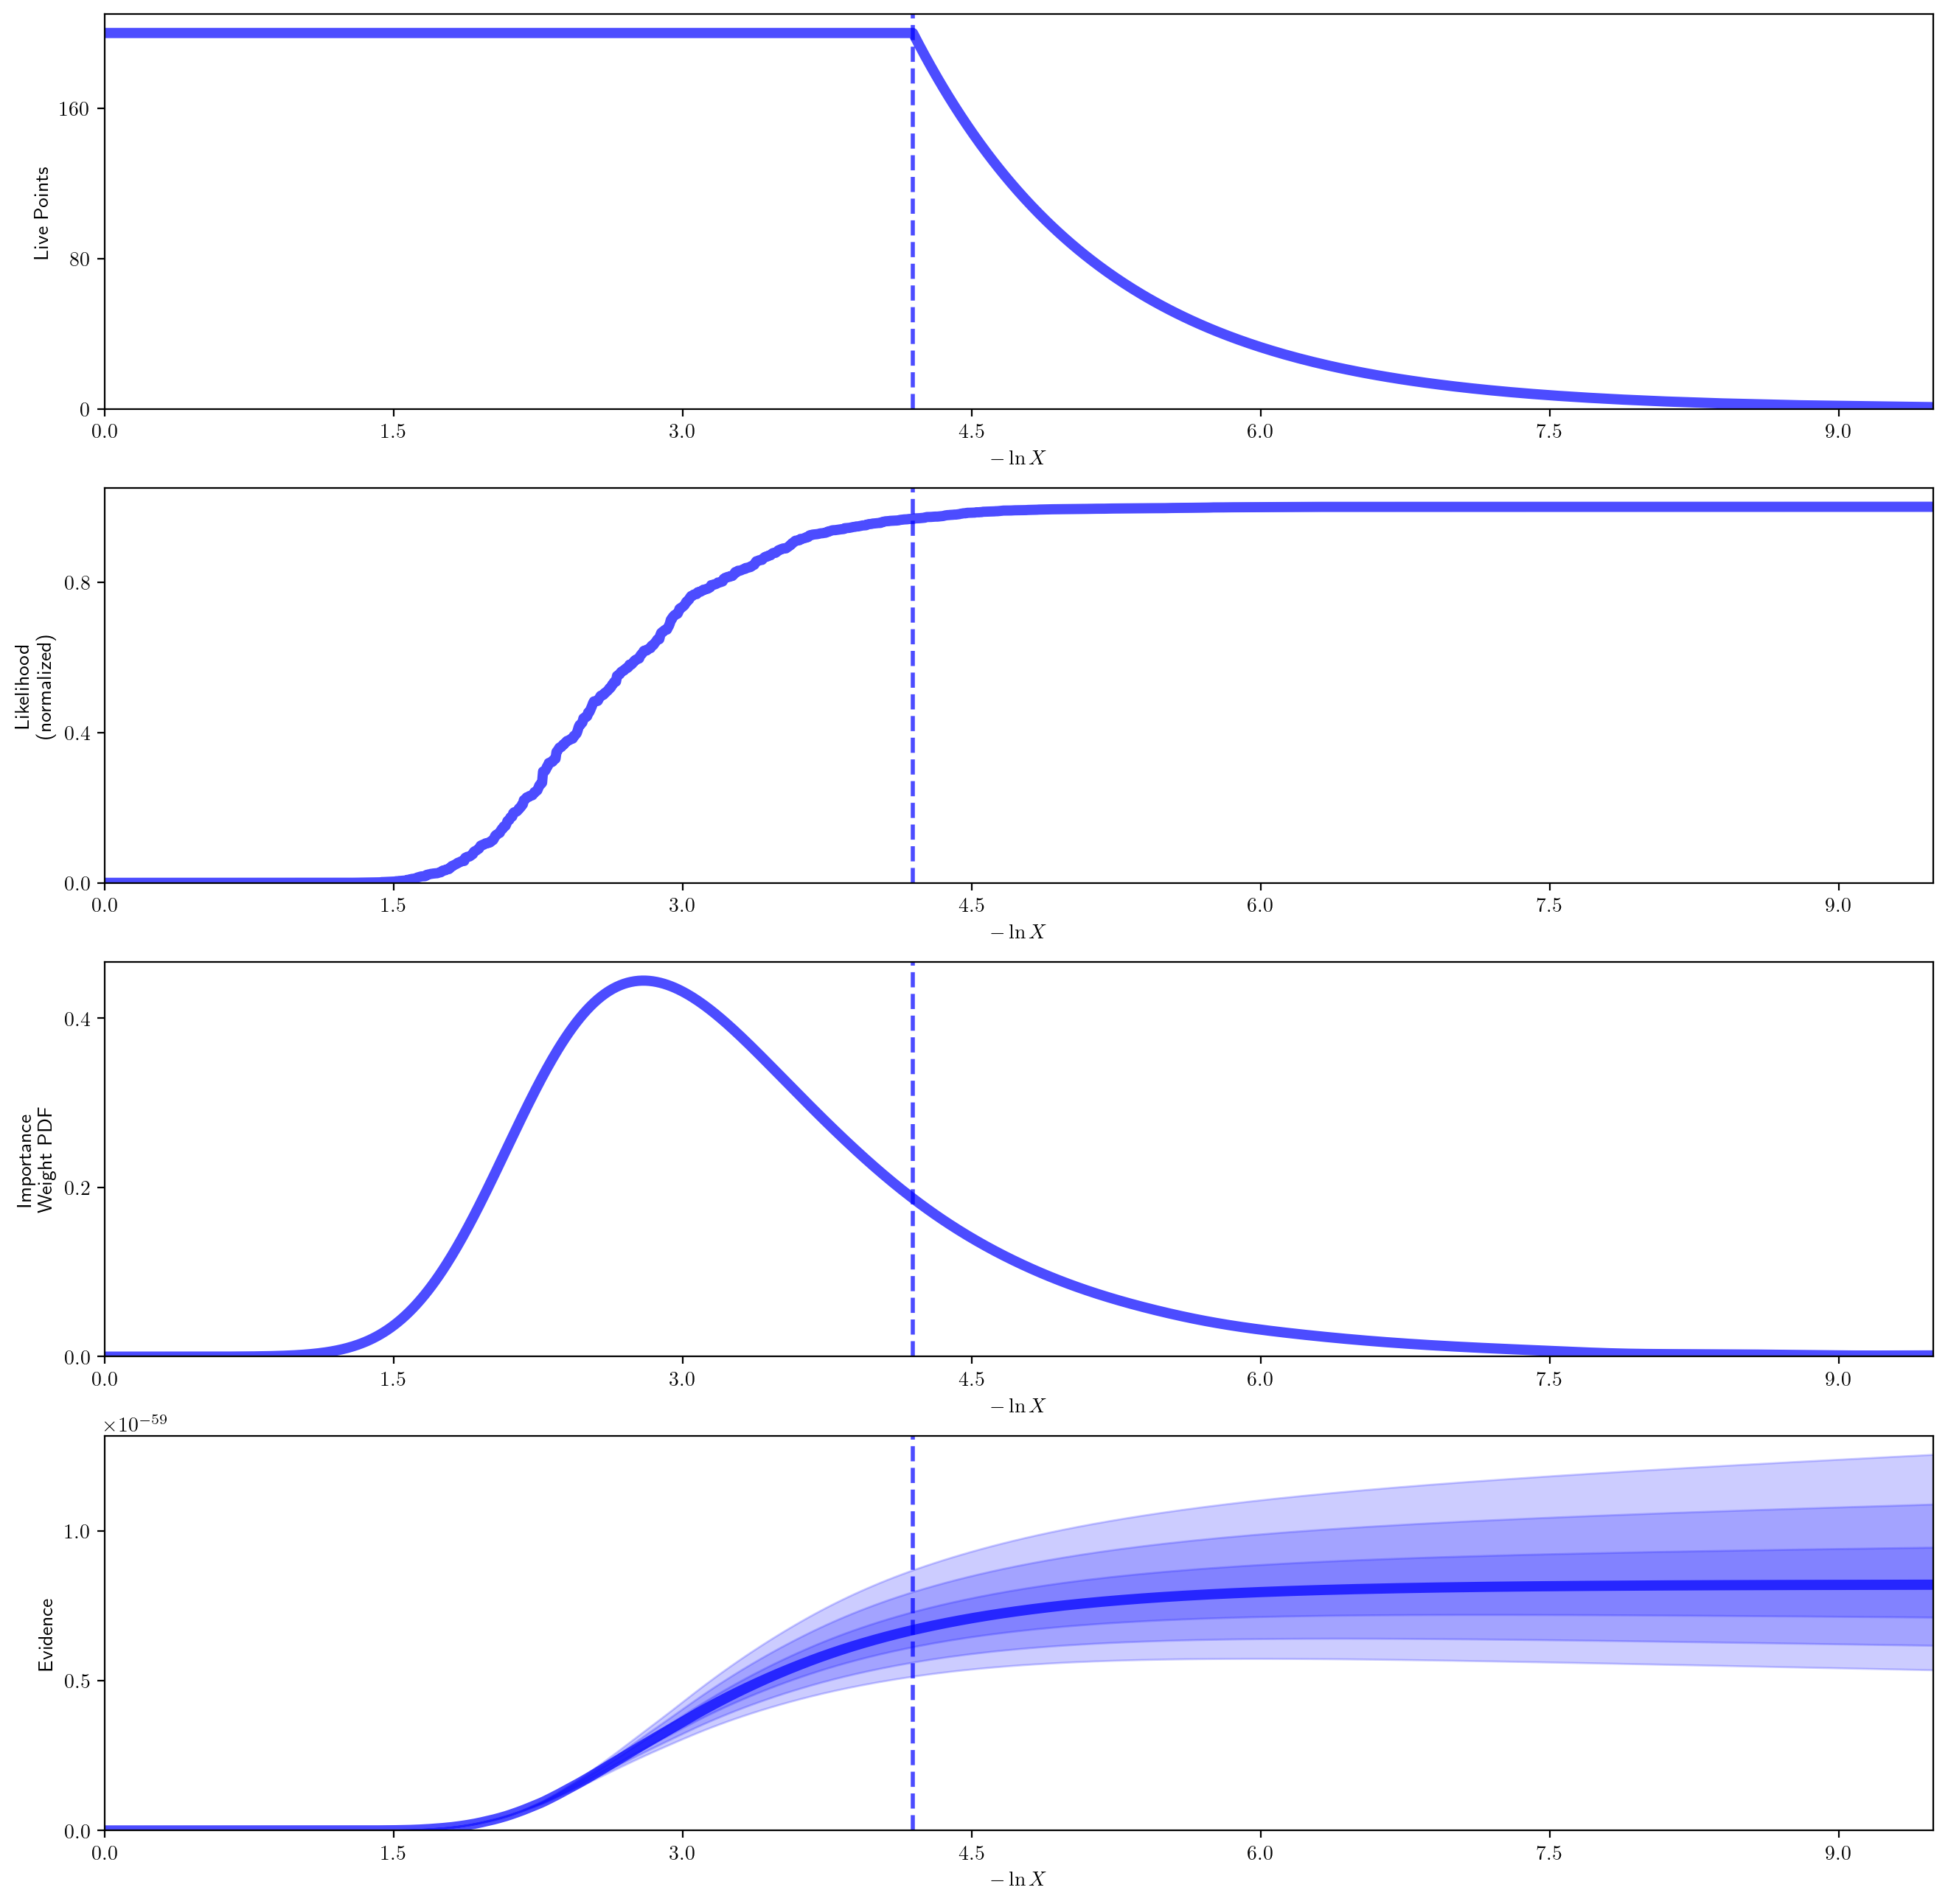

In [21]:
runplot_fig, runplot_axes = dyplot.runplot(sresults_noDM)

#### Traceplots

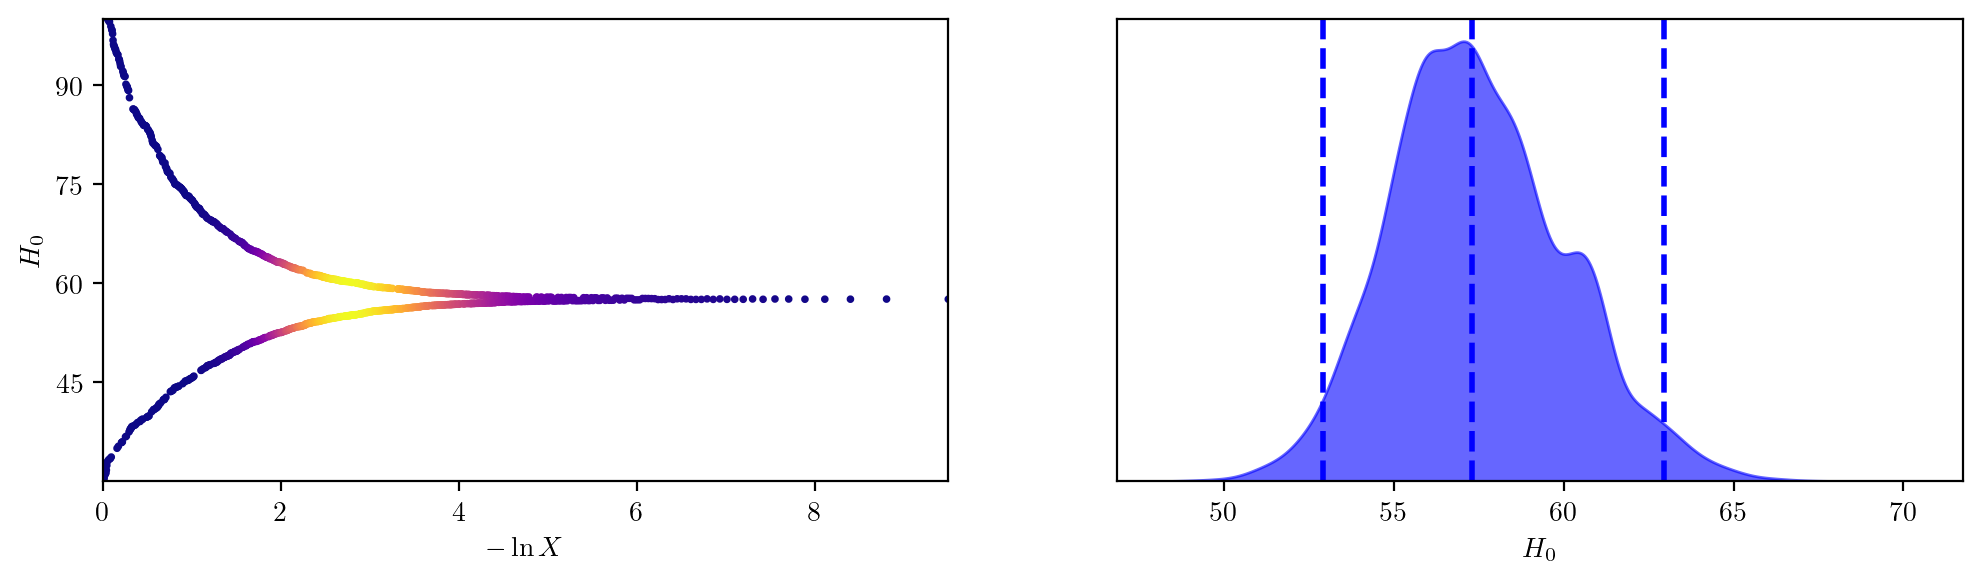

In [22]:
labels_noDM = ["$H_0$"]
traceplot_fig, traceplot_axes = dyplot.traceplot(sresults_noDM, labels=labels_noDM)

#### Corner plots

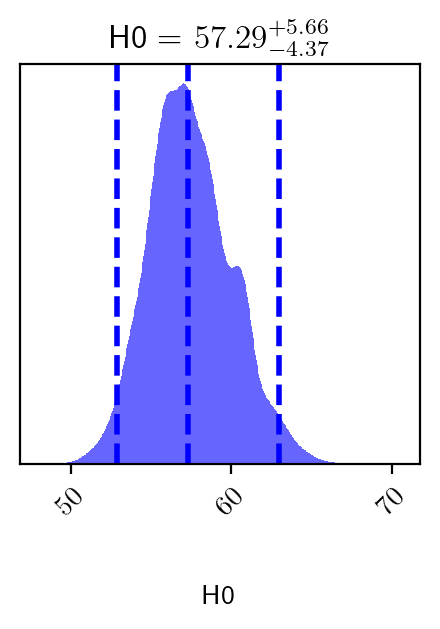

In [23]:
corner_fig, corner_axes = dyplot.cornerplot(sresults_noDM, color='b', show_titles=True, max_n_ticks=3, labels=labels)

#### Statistics

In [24]:
log_evidence_noDM = sresults_noDM.logz[-1]          
log_evidence_error_noDM = sresults_noDM.logzerr[-1]

#compute the evidence
evidence_noDM = np.exp(log_evidence_noDM)
print("Bayesian evidence:", evidence_noDM)

#propagate the error 
evidence_error_noDM = evidence_noDM * log_evidence_error_noDM
print("Bayesian evidence error:", evidence_error_noDM)

samples_noDM = sresults_noDM.samples  # samples
weights_noDM = np.exp(sresults_noDM.logwt - sresults_noDM.logz[-1])  # normalized weights

Bayesian evidence: 8.205524160621725e-60
Bayesian evidence error: 1.1635128886208488e-60


#### Plot

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


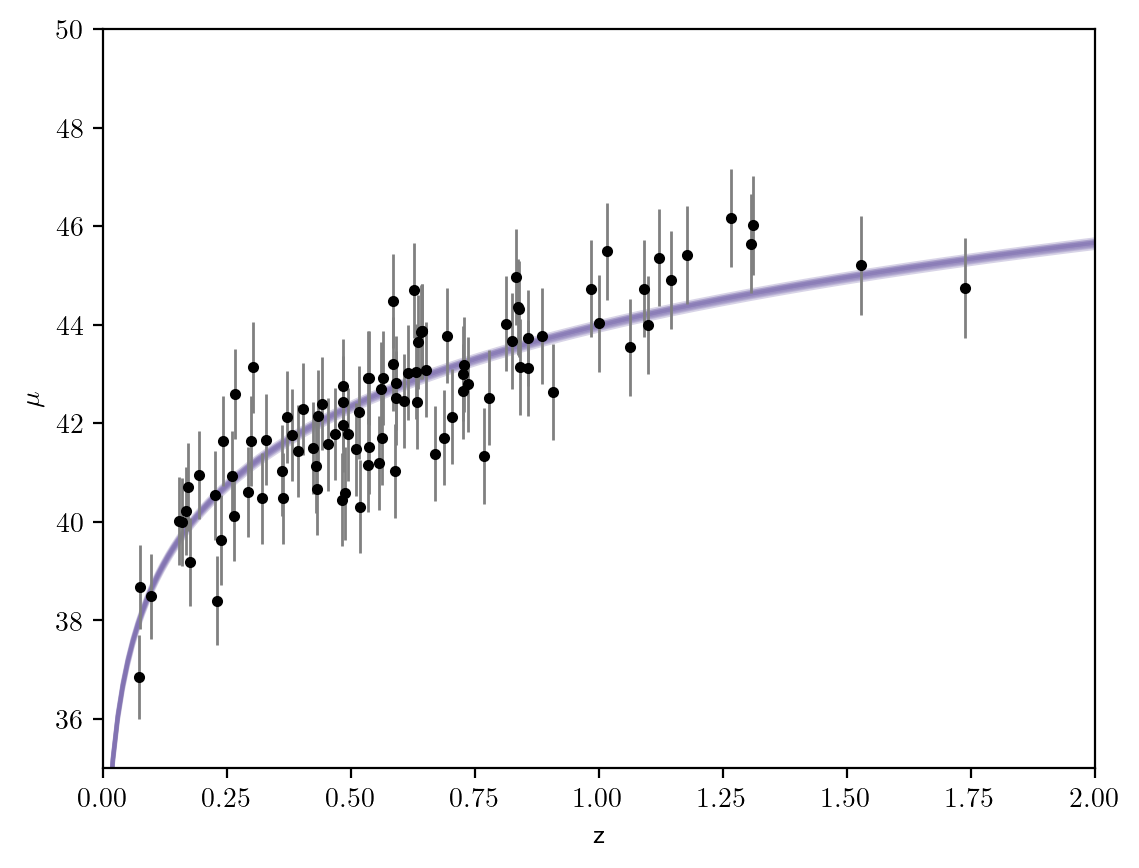

In [25]:
samples_equal_noDM = dyfunc.resample_equal(samples_noDM, weights_noDM)

for H0 in samples_equal_noDM[::100]:
    plt.plot(x_grid, dist_module(x_grid, float(H0[0]), Om=1),c='C3',alpha=0.3)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Model comparison

In [26]:
bayes_factor = evidence_noDM/evidence
print('Bayes factor: ' + str(bayes_factor))

# propagate the error
bayes_factor_error = bayes_factor * np.sqrt((evidence_error_noDM/evidence_noDM)**2 + (evidence_error/evidence)**2)
print('Bayes factor error: ' + str(bayes_factor_error))

Bayes factor: 0.49209379973536255
Bayes factor error: 0.09773312810592724


In [27]:
def bayes_factor_to_jeffreys(bf):
    if bf < 1:
        return "Negative"
    elif 1 <= bf < 3:
        return "Barely worth mentioning"
    elif 3 <= bf < 10:
        return "Substantial"
    elif 10 <= bf < 30:
        return "Strong"
    elif 30 <= bf < 100:
        return "Very strong"
    elif bf >= 100:
        return "Decisive"

In [28]:
print('Jeffrey scale: ' + bayes_factor_to_jeffreys(bayes_factor))

Jeffrey scale: Negative


## Cloning data

In [29]:
z_new = np.random.choice(z_sample, size=10 * len(z_sample), replace=True)

In [30]:
# GPR
mu_gpr, mu_gpr_err = GPR.predict(z_new[:, None], return_std=True)
mu_gpr = np.random.normal(loc=mu_gpr,scale=mu_gpr_err)

# distance module
mu_lcdm = dist_module(z_new, quantiles[0,0], quantiles[1,0])

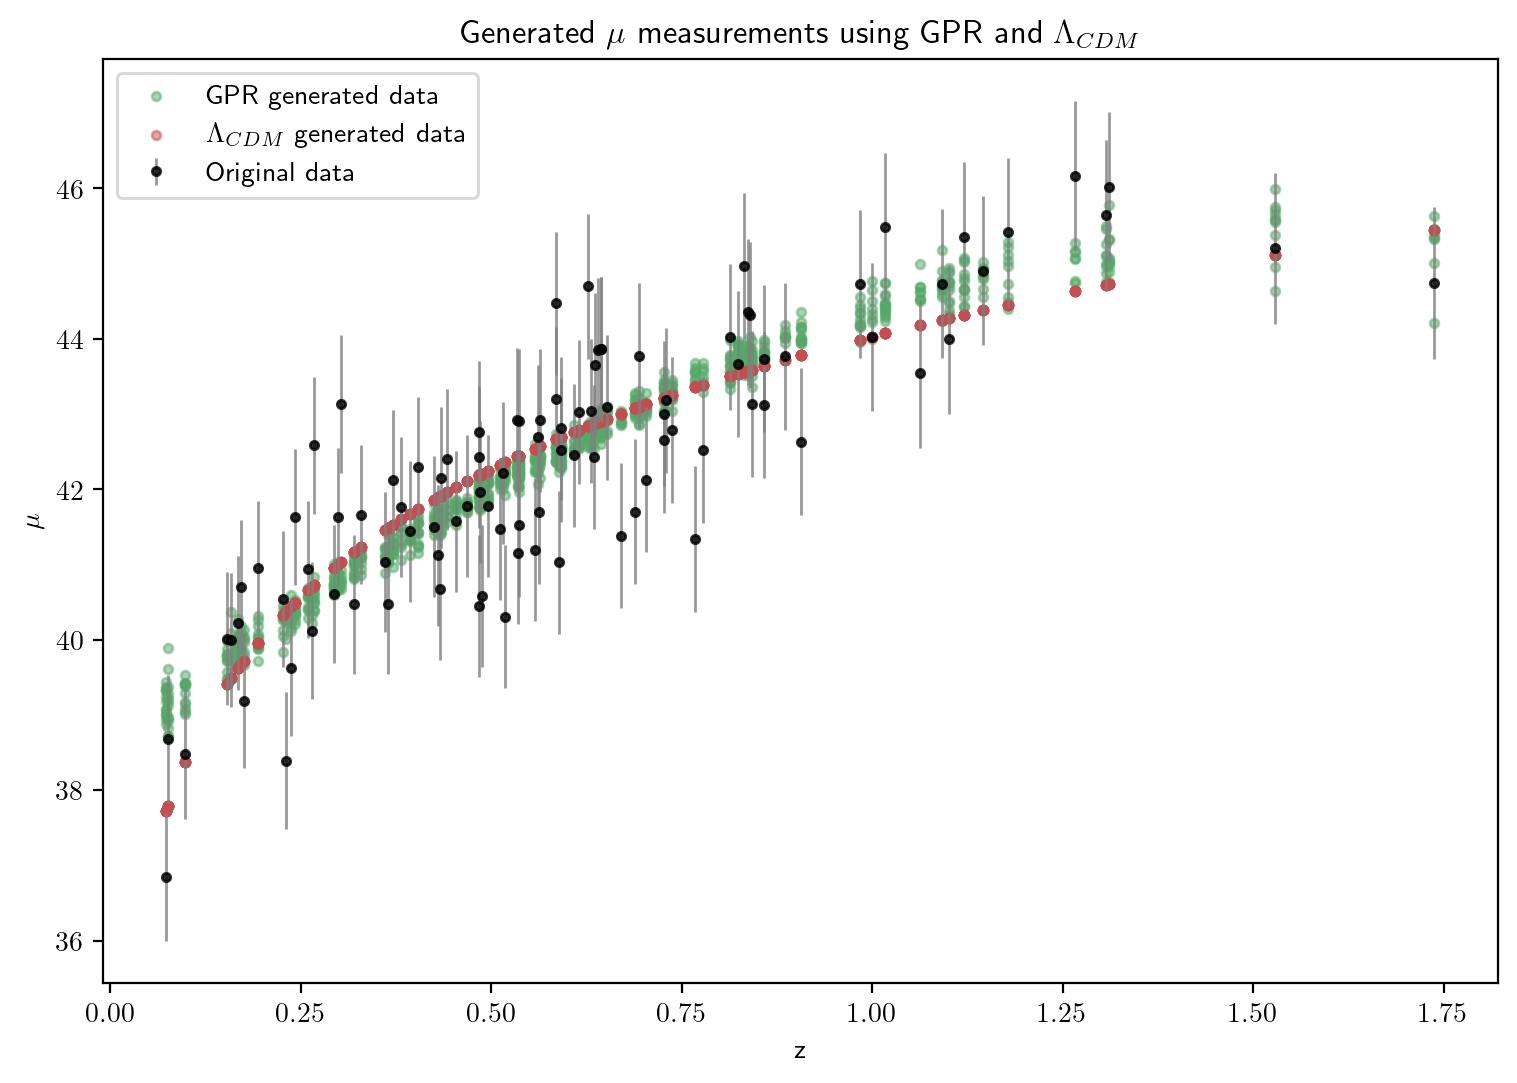

In [36]:
plt.figure(figsize=(9, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', alpha=0.8, lw=1, label='Original data')
plt.scatter(z_new, mu_gpr, color='C1', s=10, alpha=0.5, label='GPR generated data')
plt.scatter(z_new, mu_lcdm, color='C2', s=10, alpha=0.5, label=r'$\Lambda_{CDM}$ generated data')
plt.xlabel(r"z")
plt.ylabel(r"$\mu$")
plt.title(r"Generated $\mu$ measurements using GPR and $\Lambda_{CDM}$")
plt.legend()
plt.show()